# Calculate divergence and plot it

In [1]:
from vem import vem, plot_solution
import numpy as np


# Definition of the harmonic function
real_solution = lambda x, y: np.exp(x)*np.sin(y)
domain_rhs = lambda point: 0
domain_boundary_condition = lambda points: real_solution(points[:, 0], points[:, 1])

# Size of the mesh
mesh1_num = 500
mesh2_num = 5000
mesh3_num = 10000

folder = "polyllaMeshes/"

# Meshes
filemesh1 = folder + str(mesh1_num) + "uniform.polylla.mat"
filemesh2 = folder + str(mesh2_num) + "uniform.polylla.mat"
filemesh3 = folder + str(mesh3_num) + "uniform.polylla.mat"


## Calculation of the divergence

Para calcular la div se aplica la formula 

$$e^2_\Omega = \sum_{t\in T} A_t \cdot (\tilde{u_t} - u(\overrightarrow{c_t}))^2$$

Por lo que a cada elemento de Polylla, se triangula y se calcula el area de cada triangulo. Luego se calcula el centroide de cada triangulo y se calcula la diferencia entre el valor de la solucion en el centroide y el valor de la solucion en el centroide de la malla original. Finalmente se calcula el producto punto entre el vector normal al triangulo y el vector diferencia.

El comentario de arriba los hizo copilot, no yo. Este igual lakdlasdklaskl

In [2]:
import scipy.io
import triangle as triangle_quake

def get_error_mesh(mesh_file, real_solution, aprox_solution):
    u_sol_triangle_centroid = []
    area_triangles = []
    u_chancho_triangles = []

    mesh =  scipy.io.loadmat(mesh_file)
    elements_mesh =  np.array([i[0].reshape(-1) - 1 for i in mesh['elements']])
    vertices_mesh = mesh['vertices']

    for el in elements_mesh:
        t = triangle_quake.triangulate({'vertices': vertices_mesh[el], 'segments': [(i, (i+1) % len(el) )  for i in range(len(el))] }, 'p')
        triangles = t['triangles']
        vertices = vertices_mesh[el]
        for trian in triangles:
            #Get 3 vertices of the triangle
            points =  np.array([ np.array([vertices[i][0], vertices[i][1]]) for i in trian])
            #Get the solution in the 3 vertices of the triangle, summ all the values and divide by 3
            u_chancho_t = np.sum(np.array([aprox_solution[np.where(np.all(vertices_mesh==p,axis=1))[0]] for p in points]))/3
            u_chancho_triangles.append(u_chancho_t)
            #Get the area of the triangle
            area_t = np.linalg.norm(np.cross(points[1]-points[0], points[2]-points[0]))/2
            area_triangles.append(area_t)

            #calculate center of mass of the triangle
            center = np.sum(points, axis=0)/3
            #calculate the solution in the centroid of the triangle
            u_sol_triangle_centroid.append(real_solution(center[0], center[1]))

    e_mesh3 = np.sqrt(np.sum( np.array(area_triangles)*(np.array(u_sol_triangle_centroid) - np.array(u_chancho_triangles))**2))
    return e_mesh3, len(elements_mesh)


In [3]:
u_1 = vem(filemesh1, domain_rhs, domain_boundary_condition)
u_2 = vem(filemesh2, domain_rhs, domain_boundary_condition)
u_3 = vem(filemesh3, domain_rhs, domain_boundary_condition)


In [4]:
e_mesh1, n_mesh1 = get_error_mesh(filemesh1, real_solution, u_1)
e_mesh2, n_mesh2 = get_error_mesh(filemesh2, real_solution, u_2)
e_mesh3, n_mesh3 = get_error_mesh(filemesh3, real_solution, u_3)

print("Error mesh 1: ", e_mesh1)
print("Error mesh 2: ", e_mesh2)
print("Error mesh 3: ", e_mesh3)

Error mesh 1:  0.00035445135789198616
Error mesh 2:  3.6035490991812565e-05
Error mesh 3:  1.7504906195989823e-05


## Plot divergence

Text(0, 0.5, 'ln($e_\\Omega$)')

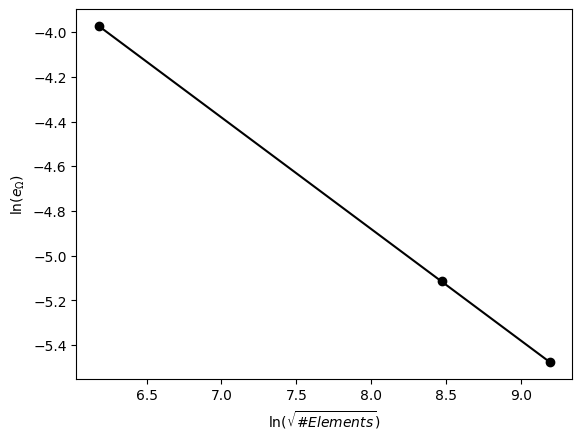

In [17]:
from matplotlib import pyplot as plt

x = np.array([n_mesh1, n_mesh2, n_mesh3])
y = np.array([e_mesh1, e_mesh2, e_mesh3])

plt.plot(np.log(x), np.log(np.sqrt(y)), '-ok')
plt.xlabel('ln($\sqrt{\# Elements}$)')
plt.ylabel('ln($e_\Omega$)')
